In [6]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Polygon
from ensemble_boxes import weighted_boxes_fusion

# ================= PATH CONFIGURATION =================
BASE_DIR = os.path.dirname(os.getcwd())  # Go up one level from your notebook folder

ICDAR_IMAGE_DIR = os.path.join(BASE_DIR, "test-images", "ch4_test_images")
GT_DIR = os.path.join(BASE_DIR, "test-images", "Challenge4_Test_Task1_GT")
OUTPUT_DIR = os.path.join(BASE_DIR, "outputs")

EAST_DIR  = os.path.join(OUTPUT_DIR, "east")
CRAFT_DIR = os.path.join(OUTPUT_DIR, "craft")
FUSED_DIR = os.path.join(OUTPUT_DIR, "fused")

os.makedirs(FUSED_DIR, exist_ok=True)

print(f"Images: {ICDAR_IMAGE_DIR}")
print(f"Ground Truth: {GT_DIR}")
print(f"EAST predictions: {EAST_DIR}")
print(f"CRAFT predictions: {CRAFT_DIR}")
print(f"Fused output: {FUSED_DIR}")

Images: x:\Project I 7th sem\test-images\ch4_test_images
Ground Truth: x:\Project I 7th sem\test-images\Challenge4_Test_Task1_GT
EAST predictions: x:\Project I 7th sem\outputs\east
CRAFT predictions: x:\Project I 7th sem\outputs\craft
Fused output: x:\Project I 7th sem\outputs\fused


In [2]:
def load_icdar_file(file_path, img_width, img_height):
    """
    Reads an ICDAR text file (x1,y1...x4,y4, score).
    Returns: normalized boxes [[x1, y1, x2, y2]], scores [s1], polygons (original coords) for WBF.
    """
    boxes = []
    scores = []
    polygons = []
    
    if not os.path.exists(file_path):
        return [], [], []

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
        
    for line in lines:
        parts = line.strip().split(',')
        try:
            coords = [float(x) for x in parts[:8]]
            
            if len(parts) > 8:
                score = float(parts[8])
            else:
                score = 1.0
            
            # Convert 8-point polygon to bounding box with normalized coordinates
            xs = coords[0::2]
            ys = coords[1::2]
            
            xmin = max(0, min(xs) / img_width)
            ymin = max(0, min(ys) / img_height)
            xmax = min(1, max(xs) / img_width)
            ymax = min(1, max(ys) / img_height)
            
            boxes.append([xmin, ymin, xmax, ymax])
            scores.append(score)
            polygons.append(coords)
        except ValueError:
            continue
            
    return boxes, scores, polygons

def save_fused_file_with_polygons(file_path, polygons, scores):
    """
    Saves WBF output using original polygon shapes.
    """
    with open(file_path, 'w') as f:
        for poly, score in zip(polygons, scores):
            coords = [str(int(c)) for c in poly]
            line = ','.join(coords) + f',{score:.4f}\n'
            f.write(line)

In [3]:
# Fusion parameters
MODEL_WEIGHTS = [1, 1]
IOU_THR = 0.45
SKIP_BOX_THR = 0.30
REQUIRE_AGREEMENT = True
AGREEMENT_IOU_THRESH = 0.35

image_files = glob.glob(os.path.join(ICDAR_IMAGE_DIR, '*'))
print(f"Starting fusion on {len(image_files)} files...")

for img_path in tqdm(image_files):
    filename = os.path.basename(img_path)
    name_no_ext = os.path.splitext(filename)[0]
    txt_name = f"{name_no_ext}.txt"
    
    east_path = os.path.join(EAST_DIR, txt_name)
    craft_path = os.path.join(CRAFT_DIR, txt_name)
    save_path = os.path.join(FUSED_DIR, txt_name)
    
    img = cv2.imread(img_path)
    if img is None: continue
    h, w, _ = img.shape
    
    # Load predictions with original polygons
    boxes_list, scores_list, labels_list = [], [], []
    all_polygons = []
    
    # Load EAST predictions
    b1, s1, p1 = load_icdar_file(east_path, w, h)
    if b1:
        boxes_list.append(b1)
        scores_list.append(s1)
        labels_list.append([0] * len(b1))
        all_polygons.extend([(poly, 'east', i) for i, poly in enumerate(p1)])
        
    # Load CRAFT predictions
    b2, s2, p2 = load_icdar_file(craft_path, w, h)
    if b2:
        boxes_list.append(b2)
        scores_list.append(s2)
        labels_list.append([0] * len(b2))
        all_polygons.extend([(poly, 'craft', i) for i, poly in enumerate(p2)])
    
    if not boxes_list:
        with open(save_path, 'w') as f: pass
        continue

    # Apply weighted box fusion
    fused_boxes, fused_scores, fused_labels = weighted_boxes_fusion(
        boxes_list,
        scores_list,
        labels_list,
        weights=MODEL_WEIGHTS[:len(boxes_list)],
        iou_thr=IOU_THR,
        skip_box_thr=SKIP_BOX_THR
    )
    
    # Agreement-based filtering
    if REQUIRE_AGREEMENT and len(boxes_list) == 2:
        filtered_boxes = []
        filtered_scores = []
        filtered_indices = []
        
        for idx, (fused_box, fused_score) in enumerate(zip(fused_boxes, fused_scores)):
            fx1, fy1, fx2, fy2 = fused_box
            
            east_overlap = False
            for b in b1:
                iou = max(0, min(fx2, b[2]) - max(fx1, b[0])) * max(0, min(fy2, b[3]) - max(fy1, b[1]))
                union = (fx2 - fx1) * (fy2 - fy1) + (b[2] - b[0]) * (b[3] - b[1]) - iou
                if iou / (union + 1e-6) > AGREEMENT_IOU_THRESH:
                    east_overlap = True
                    break
            
            craft_overlap = False
            for b in b2:
                iou = max(0, min(fx2, b[2]) - max(fx1, b[0])) * max(0, min(fy2, b[3]) - max(fy1, b[1]))
                union = (fx2 - fx1) * (fy2 - fy1) + (b[2] - b[0]) * (b[3] - b[1]) - iou
                if iou / (union + 1e-6) > AGREEMENT_IOU_THRESH:
                    craft_overlap = True
                    break
            
            if east_overlap and craft_overlap:
                filtered_boxes.append(fused_box)
                filtered_scores.append(fused_score)
                filtered_indices.append(idx)
        
        fused_boxes = np.array(filtered_boxes) if filtered_boxes else np.array([])
        fused_scores = np.array(filtered_scores) if filtered_scores else np.array([])
    
    # Map fused boxes to original polygons
    fused_polygons = []
    
    for fused_box, fused_score in zip(fused_boxes, fused_scores):
        fx1 = fused_box[0] * w
        fy1 = fused_box[1] * h
        fx2 = fused_box[2] * w
        fy2 = fused_box[3] * h
        fused_center_x = (fx1 + fx2) / 2
        fused_center_y = (fy1 + fy2) / 2
        
        best_poly = None
        best_dist = float('inf')
        
        for poly, source, idx in all_polygons:
            xs = [poly[i] for i in range(0, 8, 2)]
            ys = [poly[i] for i in range(1, 8, 2)]
            poly_center_x = sum(xs) / 4
            poly_center_y = sum(ys) / 4
            
            dist = ((fused_center_x - poly_center_x)**2 + (fused_center_y - poly_center_y)**2)**0.5
            
            poly_xmin, poly_xmax = min(xs), max(xs)
            poly_ymin, poly_ymax = min(ys), max(ys)
            
            xi1 = max(fx1, poly_xmin)
            yi1 = max(fy1, poly_ymin)
            xi2 = min(fx2, poly_xmax)
            yi2 = min(fy2, poly_ymax)
            
            inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
            box1_area = (fx2 - fx1) * (fy2 - fy1)
            box2_area = (poly_xmax - poly_xmin) * (poly_ymax - poly_ymin)
            iou = inter_area / (box1_area + box2_area - inter_area + 1e-6)
            
            if iou > 0.3 and dist < best_dist:
                best_dist = dist
                best_poly = poly
        
        if best_poly is not None:
            fused_polygons.append(best_poly)
        else:
            fused_polygons.append([
                int(fx1), int(fy1),
                int(fx2), int(fy1),
                int(fx2), int(fy2),
                int(fx1), int(fy2)
            ])
    
    save_fused_file_with_polygons(save_path, fused_polygons, fused_scores)

print("Fusion complete.")

Starting fusion on 500 files...


100%|██████████| 500/500 [00:28<00:00, 17.35it/s]

Fusion complete.


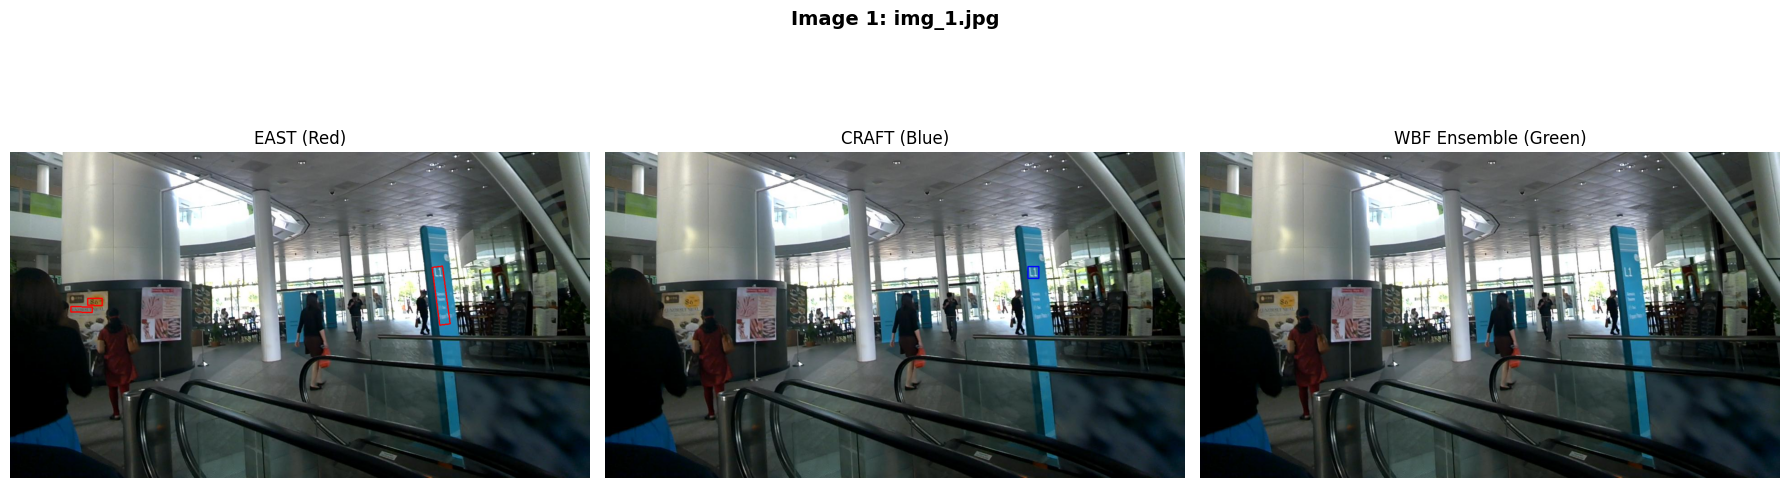

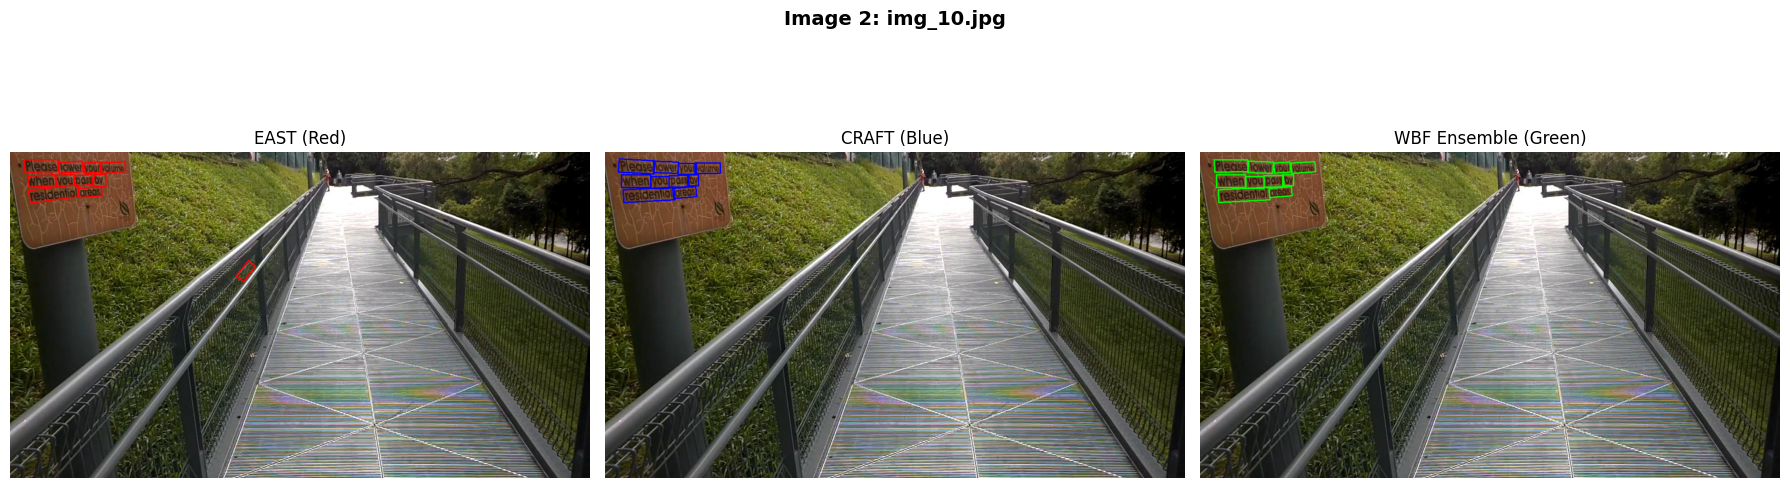

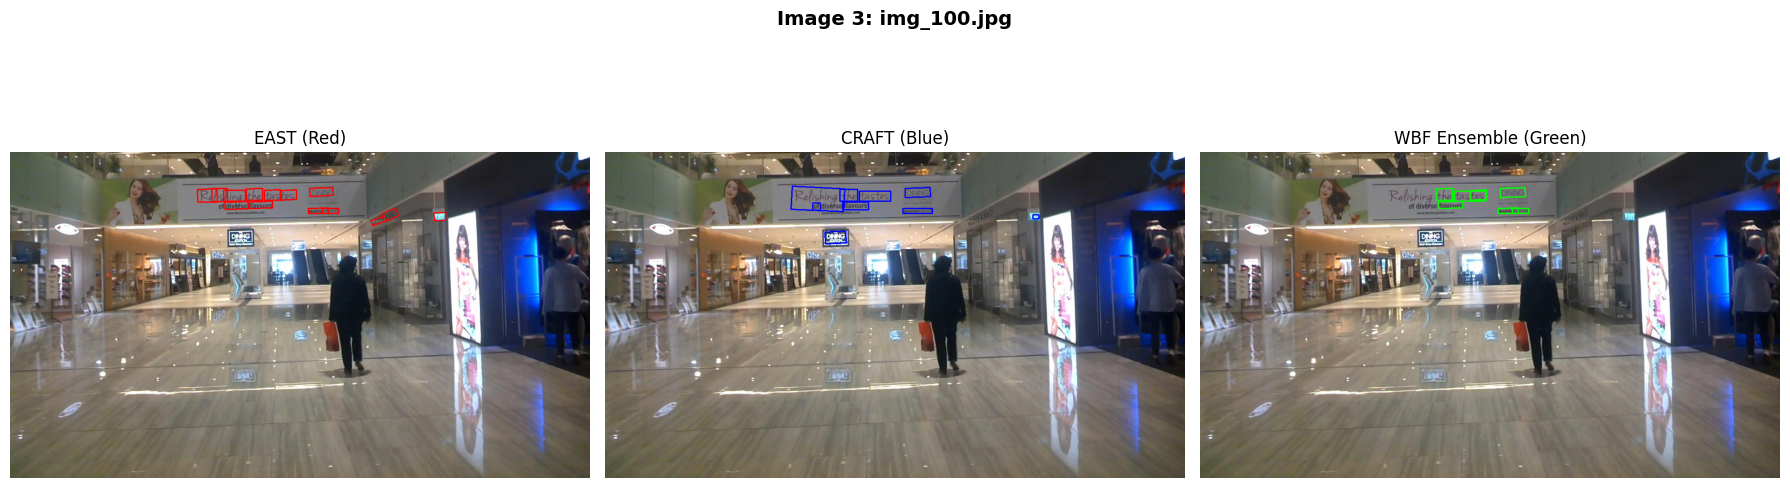

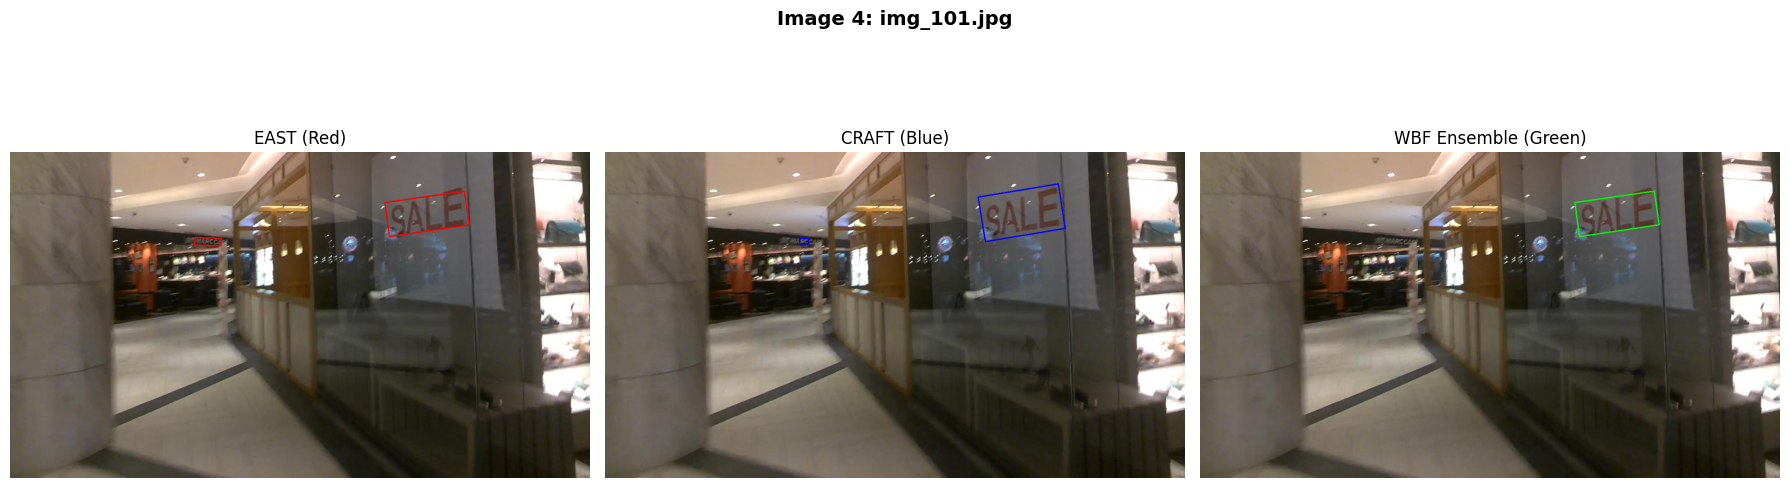

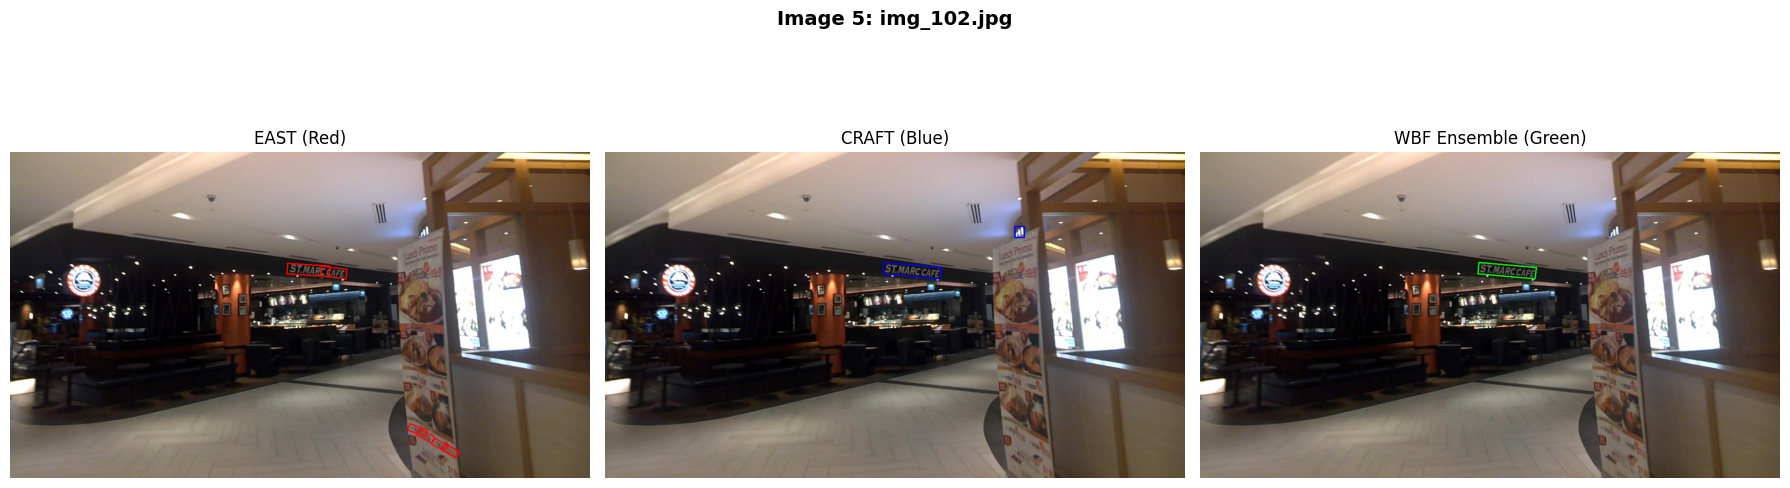

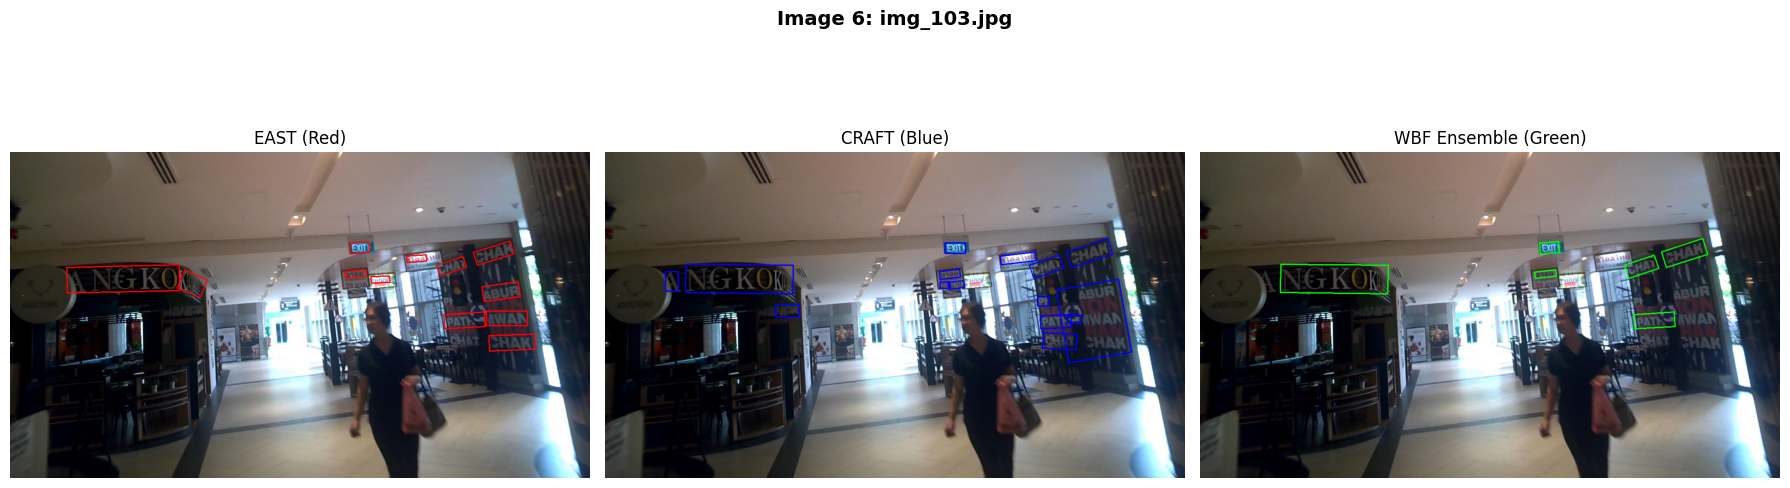

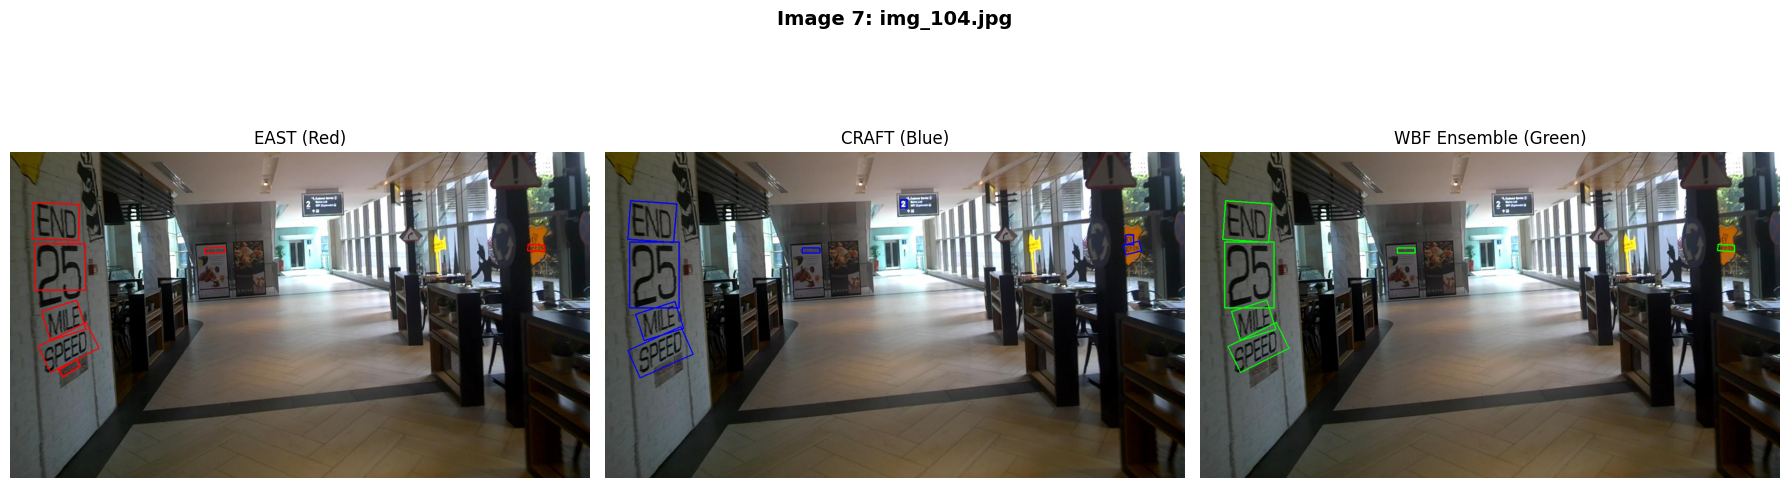

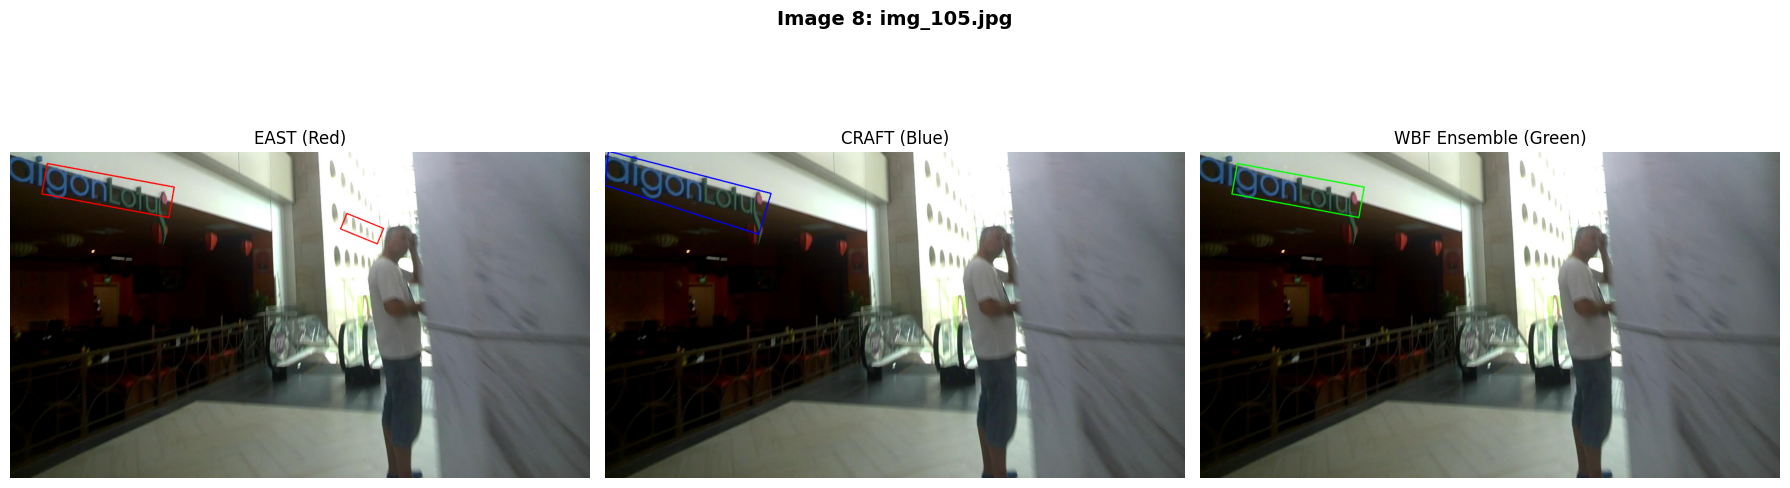

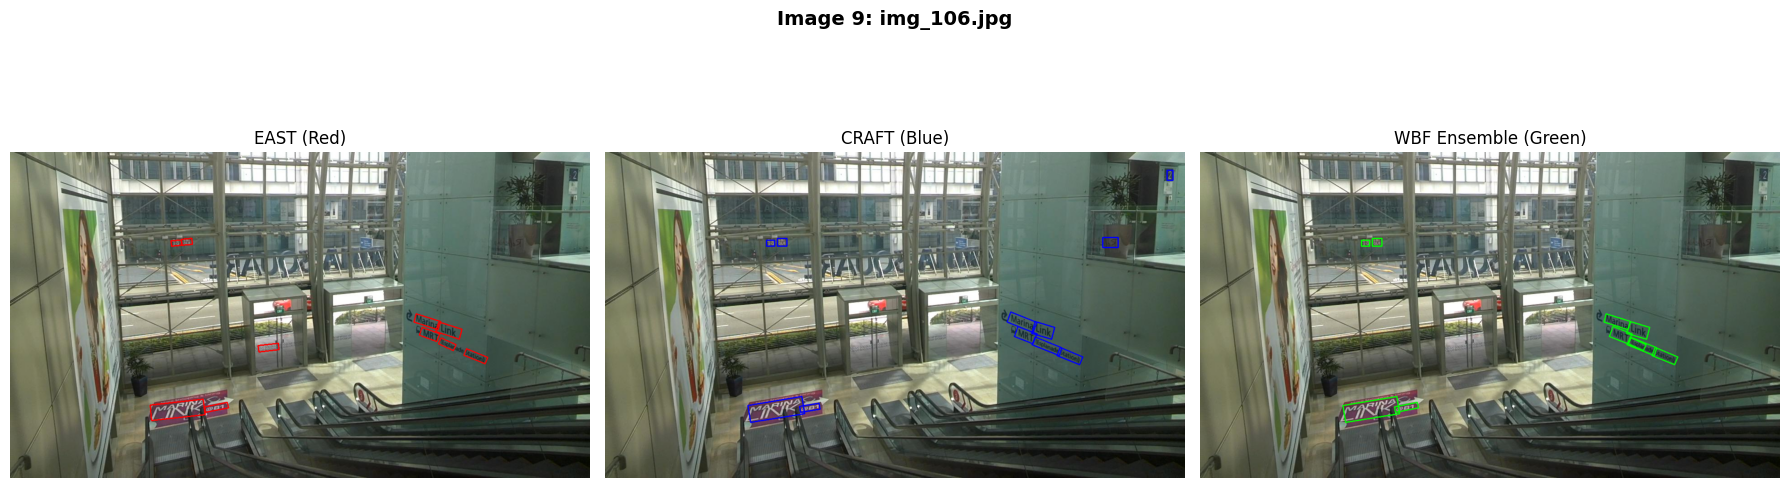

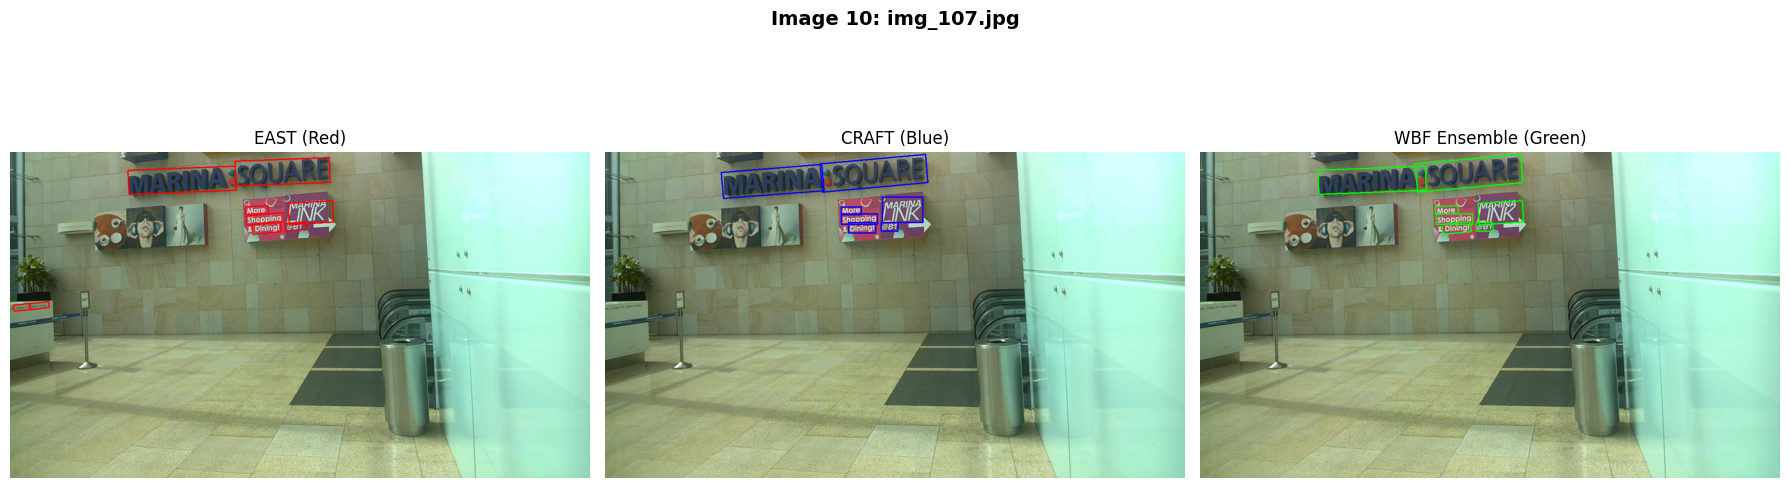


Displayed 10 image comparisons


In [4]:
def draw_boxes(image, txt_path, color=(0, 255, 0), thickness=2):
    """Parses ICDAR txt file and draws boxes on the image."""
    canvas = image.copy()
    if not os.path.exists(txt_path): return canvas
    
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            try:
                coords = [int(float(x)) for x in parts[:8]]
                pts = np.array(coords).reshape((-1, 1, 2))
                cv2.polylines(canvas, [pts], isClosed=True, color=color, thickness=thickness)
            except: continue
    return canvas

# Select first 10 images
all_images = sorted(glob.glob(os.path.join(ICDAR_IMAGE_DIR, '*')))
sample_images = all_images[:10]

# Process each image comparison separately
for img_idx, img_path in enumerate(sample_images, 1):
    filename = os.path.basename(img_path)
    name_no_ext = os.path.splitext(filename)[0]
    txt_name = f"{name_no_ext}.txt"

    img = cv2.imread(img_path)
    if img is None: 
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    east_txt = os.path.join(EAST_DIR, txt_name)
    craft_txt = os.path.join(CRAFT_DIR, txt_name)
    fused_txt = os.path.join(FUSED_DIR, txt_name)

    # Draw Boxes
    img_east = draw_boxes(img, east_txt, color=(255, 0, 0))   # Red
    img_craft = draw_boxes(img, craft_txt, color=(0, 0, 255)) # Blue
    img_wbf = draw_boxes(img, fused_txt, color=(0, 255, 0))   # Green

    # Create individual comparison figure for each image
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f"Image {img_idx}: {filename}", fontsize=14, fontweight='bold')

    axes[0].imshow(img_east)
    axes[0].set_title("EAST (Red)", fontsize=12)
    axes[0].axis('off')

    axes[1].imshow(img_craft)
    axes[1].set_title("CRAFT (Blue)", fontsize=12)
    axes[1].axis('off')

    axes[2].imshow(img_wbf)
    axes[2].set_title("WBF Ensemble (Green)", fontsize=12)
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

print(f"\nDisplayed {len(sample_images)} image comparisons")

In [5]:
def get_polygon_iou(poly1_coords, poly2_coords):
    """Calculates IoU between two 8-point polygons."""
    try:
        p1 = Polygon(np.array(poly1_coords).reshape(4, 2))
        p2 = Polygon(np.array(poly2_coords).reshape(4, 2))
        if not p1.is_valid or not p2.is_valid: return 0.0
        inter = p1.intersection(p2).area
        union = p1.area + p2.area - inter
        return inter / union if union > 0 else 0.0
    except: return 0.0

def load_coords_with_labels(txt_path):
    """
    Load coordinates from ICDAR GT file, separating care and don't-care regions.
    Returns: care_boxes (list), dontcare_boxes (list)
    """
    care_boxes = []
    dontcare_boxes = []
    
    if not os.path.exists(txt_path):
        return care_boxes, dontcare_boxes
    
    with open(txt_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            parts = line.strip().split(',')
            try:
                coords = [int(float(x)) for x in parts[:8]]
                
                if len(parts) > 8:
                    transcription = ','.join(parts[8:]).strip().strip('"')
                    if transcription == "###":
                        dontcare_boxes.append(coords)
                    else:
                        care_boxes.append(coords)
                else:
                    care_boxes.append(coords)
            except:
                continue
    
    return care_boxes, dontcare_boxes

def load_pred_coords(txt_path):
    """Load prediction coordinates."""
    coords_list = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r', encoding='utf-8-sig') as f:
            for line in f:
                parts = line.strip().split(',')
                try:
                    c = [int(float(x)) for x in parts[:8]]
                    coords_list.append(c)
                except: continue
    return coords_list

def evaluate_folder(pred_dir, gt_dir, iou_thresh=0.5):
    """
    Evaluate predictions following ICDAR-15 protocol:
    - Only count 'care' GT boxes (exclude "###" don't-care regions)
    - Predictions overlapping don't-care regions are ignored (not FP)
    - IoU threshold: 0.5
    """
    tp, fp, fn = 0, 0, 0
    gt_files = glob.glob(os.path.join(gt_dir, 'gt_*.txt'))
    
    for gt_path in tqdm(gt_files, desc=f"Eval {os.path.basename(pred_dir)}", leave=False):
        filename = os.path.basename(gt_path)
        pred_filename = filename[3:]
        pred_path = os.path.join(pred_dir, pred_filename)
        
        care_boxes, dontcare_boxes = load_coords_with_labels(gt_path)
        pred_boxes = load_pred_coords(pred_path)
        
        matched_gt = [False] * len(care_boxes)
        
        for p_box in pred_boxes:
            best_iou = 0
            best_gt_idx = -1
            
            for g_idx, g_box in enumerate(care_boxes):
                if matched_gt[g_idx]: 
                    continue
                iou = get_polygon_iou(p_box, g_box)
                if iou > iou_thresh and iou > best_iou:
                    best_iou = iou
                    best_gt_idx = g_idx
            
            if best_gt_idx >= 0:
                matched_gt[best_gt_idx] = True
                tp += 1
                continue
            
            is_dontcare = False
            for dc_box in dontcare_boxes:
                iou_dc = get_polygon_iou(p_box, dc_box)
                if iou_dc > iou_thresh:
                    is_dontcare = True
                    break
            
            if is_dontcare:
                continue
            
            fp += 1
        
        fn += matched_gt.count(False)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return {"TP": tp, "FP": fp, "FN": fn, "Precision": precision, "Recall": recall, "F1-Score": f1}

print("\nEvaluating with ICDAR-15 Protocol...")
results = []
results.append({"Model": "EAST", **evaluate_folder(EAST_DIR, GT_DIR)})
results.append({"Model": "CRAFT", **evaluate_folder(CRAFT_DIR, GT_DIR)})
results.append({"Model": "WBF (Ensemble)", **evaluate_folder(FUSED_DIR, GT_DIR)})

df = pd.DataFrame(results)
print("Performance Comparison Table")
display(df.style.format({"Precision": "{:.2%}", "Recall": "{:.2%}", "F1-Score": "{:.2%}"}))


Evaluating with ICDAR-15 Protocol...


Performance Comparison Table


## Ensemble Text Detection on Custom Image

Use this cell to detect text in any image using the ensemble approach (EAST + CRAFT + WBF)

✅ CRAFT compatibility patches applied
Processing: WhatsApp Image 2025-12-19 at 13.10.23.jpeg
  Running EAST detection...
  Running CRAFT detection...
  Running CRAFT detection...


c:\ProgramData\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\py38\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


  EAST found: 7 boxes
  CRAFT found: 19 boxes
  Applying Weighted Box Fusion...
  Applying agreement filtering...
  Mapping to original polygons...
  ✅ Final ensemble result: 0 text regions detected


c:\ProgramData\anaconda3\envs\py38\lib\site-packages\ensemble_boxes\ensemble_boxes_wbf.py:66: UserWarning: Zero area box skipped: [0.253125, 0.46328125, 0.38229166666666664, 0.46328125].
  warnings.warn("Zero area box skipped: {}.".format(box_part))


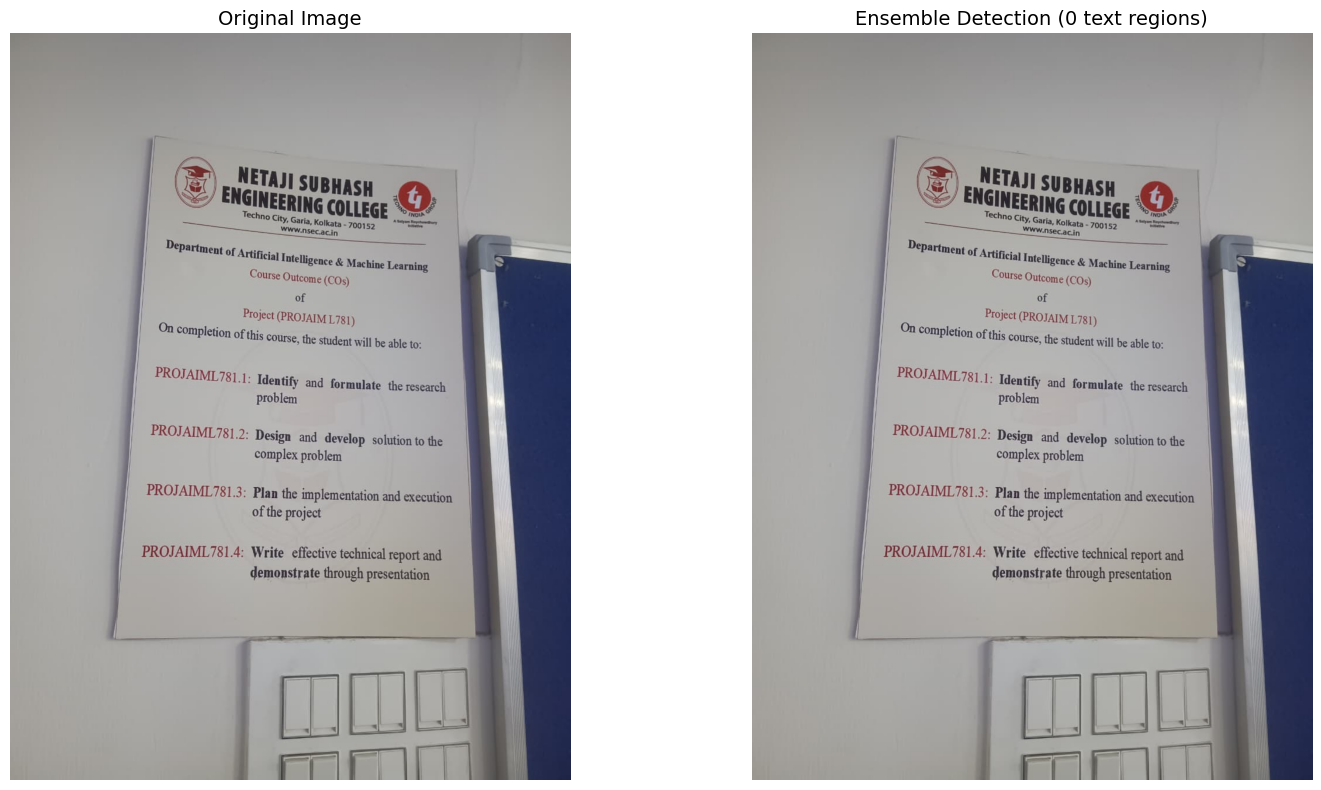


📊 Detection Summary:
   Image: WhatsApp Image 2025-12-19 at 13.10.23.jpeg
   Total text regions detected: 0
   No detections


In [7]:
# ================= CUSTOM IMAGE ENSEMBLE TEXT DETECTION =================
# Specify your image path here
USER_IMAGE_PATH = r"X:\Project I 7th sem\WhatsApp Image 2025-12-19 at 13.10.23.jpeg"  # Change this to your image path

# Load required models and libraries
import torch
import torchvision.models.vgg as vgg_module

# Apply compatibility patches for CRAFT
if not hasattr(vgg_module, 'model_urls'):
    vgg_module.model_urls = {
        'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
    }

from craft_text_detector import Craft, craft_utils

# ===== COMPREHENSIVE NUMPY COMPATIBILITY PATCH =====
# Only apply patch if not already applied
if not hasattr(np.array, '_is_patched'):
    _original_np_array = np.array
    
    def _patched_np_array(arr_input, dtype=None, **kwargs):
        """Patched numpy array that uses object dtype for heterogeneous sequences"""
        try:
            return _original_np_array(arr_input, dtype=dtype, **kwargs)
        except ValueError as e:
            error_msg = str(e)
            if "inhomogeneous shape" in error_msg or "setting an array element with a sequence" in error_msg:
                return _original_np_array(arr_input, dtype=object)
            raise
    
    _patched_np_array._is_patched = True
    np.array = _patched_np_array

# Numpy compatibility patch for CRAFT
def patched_adjustResultCoordinates(polys, ratio_w, ratio_h, ratio_net=2):
    if len(polys) > 0:
        for k in range(len(polys)):
            if polys[k] is not None:
                polys[k] *= (ratio_w * ratio_net, ratio_h * ratio_net)
    return polys

craft_utils.adjustResultCoordinates = patched_adjustResultCoordinates
print("✅ CRAFT compatibility patches applied")

# ===== EAST MODEL SETUP =====
def letterbox_image_east(image, target_dim=1280):
    """Resize image for EAST with padding to multiple of 32"""
    orig_h, orig_w = image.shape[:2]
    longest_side = max(orig_h, orig_w)
    scale = target_dim / float(longest_side)
    
    new_w = int(round(orig_w * scale))
    new_h = int(round(orig_h * scale))
    resized = cv2.resize(image, (new_w, new_h))
    
    pad_w = (32 - (new_w % 32)) % 32
    pad_h = (32 - (new_h % 32)) % 32
    
    padded_w = new_w + pad_w
    padded_h = new_h + pad_h
    
    padded = np.zeros((padded_h, padded_w, 3), dtype=resized.dtype)
    padded[0:new_h, 0:new_w] = resized
    
    return padded, scale, pad_w, pad_h, orig_h, orig_w

def decode_east_predictions(scores, geometry, conf_thresh=0.8):
    """Decode EAST model outputs to bounding boxes"""
    num_rows, num_cols = scores.shape[2:4]
    boxes = []
    confidences = []
    
    for y in range(num_rows):
        scores_data = scores[0, 0, y]
        x0_data = geometry[0, 0, y]
        x1_data = geometry[0, 1, y]
        x2_data = geometry[0, 2, y]
        x3_data = geometry[0, 3, y]
        angles_data = geometry[0, 4, y]
        
        for x in range(num_cols):
            if scores_data[x] < conf_thresh:
                continue
            
            offset_x = x * 4.0
            offset_y = y * 4.0
            
            angle = angles_data[x]
            cos_a = np.cos(angle)
            sin_a = np.sin(angle)
            
            h = x0_data[x] + x2_data[x]
            w = x1_data[x] + x3_data[x]
            
            end_x = offset_x + cos_a * x1_data[x] + sin_a * x2_data[x]
            end_y = offset_y - sin_a * x1_data[x] + cos_a * x2_data[x]
            start_x = end_x - w * cos_a
            start_y = end_y - w * sin_a
            
            boxes.append([start_x, start_y, end_x, end_y])
            confidences.append(float(scores_data[x]))
    
    return boxes, confidences

def detect_text_east(image_path, model_path, conf_thresh=0.8, nms_thresh=0.2):
    """Run EAST text detection on an image"""
    net = cv2.dnn.readNet(model_path)
    image = cv2.imread(image_path)
    orig_h, orig_w = image.shape[:2]
    
    padded, scale, pad_w, pad_h, _, _ = letterbox_image_east(image)
    blob = cv2.dnn.blobFromImage(padded, 1.0, (padded.shape[1], padded.shape[0]), 
                                  (123.68, 116.78, 103.94), swapRB=True, crop=False)
    
    net.setInput(blob)
    scores, geometry = net.forward(["feature_fusion/Conv_7/Sigmoid", "feature_fusion/concat_3"])
    
    boxes, confidences = decode_east_predictions(scores, geometry, conf_thresh)
    
    if len(boxes) == 0:
        return []
    
    # Apply NMS
    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_thresh, nms_thresh)
    
    # Convert to polygons in original image coordinates
    polygons = []
    if len(indices) > 0:
        for i in indices.flatten():
            x1, y1, x2, y2 = boxes[i]
            
            # Scale back to original
            x1 = int(x1 / scale)
            y1 = int(y1 / scale)
            x2 = int(x2 / scale)
            y2 = int(y2 / scale)
            
            # Clip to image bounds
            x1 = max(0, min(orig_w, x1))
            y1 = max(0, min(orig_h, y1))
            x2 = max(0, min(orig_w, x2))
            y2 = max(0, min(orig_h, y2))
            
            # Convert to 8-point polygon (rotated rectangle approximation)
            polygon = [x1, y1, x2, y1, x2, y2, x1, y2]
            polygons.append((polygon, confidences[i]))
    
    return polygons

# ===== CRAFT MODEL SETUP =====
def detect_text_craft(image_path):
    """Run CRAFT text detection on an image"""
    craft_model = Craft(
        crop_type="poly",
        text_threshold=0.52,
        link_threshold=0.40,
        low_text=0.30,
        long_size=2240,
        cuda=torch.cuda.is_available()
    )
    
    prediction_result = craft_model.detect_text(image_path)
    polygons = []
    
    for region in prediction_result['boxes']:
        coords = region.reshape(-1).tolist()
        # CRAFT returns coordinates as [[x1,y1], [x2,y2], [x3,y3], [x4,y4]]
        polygon = [int(coords[0]), int(coords[1]), int(coords[2]), int(coords[3]),
                   int(coords[4]), int(coords[5]), int(coords[6]), int(coords[7])]
        polygons.append((polygon, 0.9))  # Default confidence for CRAFT
    
    return polygons

# ===== ENSEMBLE DETECTION FUNCTION =====
def ensemble_detect_text(image_path, east_model_path, use_agreement=True, agreement_thresh=0.35):
    """
    Detect text using ensemble of EAST + CRAFT + WBF
    
    Args:
        image_path: Path to input image
        east_model_path: Path to EAST frozen model
        use_agreement: Whether to require agreement between models
        agreement_thresh: IoU threshold for agreement filtering
    
    Returns:
        fused_polygons: List of detected text polygons [(x1,y1,...,x4,y4), ...]
        fused_scores: List of confidence scores
    """
    print(f"Processing: {os.path.basename(image_path)}")
    
    # Load image to get dimensions
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    h, w = img.shape[:2]
    
    # Run EAST detection
    print("  Running EAST detection...")
    east_results = detect_text_east(image_path, east_model_path)
    
    # Run CRAFT detection
    print("  Running CRAFT detection...")
    craft_results = detect_text_craft(image_path)
    
    print(f"  EAST found: {len(east_results)} boxes")
    print(f"  CRAFT found: {len(craft_results)} boxes")
    
    # Prepare for WBF
    boxes_list = []
    scores_list = []
    labels_list = []
    all_polygons = []
    
    # Add EAST predictions
    if east_results:
        east_boxes = []
        east_scores = []
        for poly, score in east_results:
            xs = [poly[i] for i in range(0, 8, 2)]
            ys = [poly[i] for i in range(1, 8, 2)]
            xmin = max(0, min(xs) / w)
            ymin = max(0, min(ys) / h)
            xmax = min(1, max(xs) / w)
            ymax = min(1, max(ys) / h)
            east_boxes.append([xmin, ymin, xmax, ymax])
            east_scores.append(score)
            all_polygons.append((poly, 'east'))
        
        boxes_list.append(east_boxes)
        scores_list.append(east_scores)
        labels_list.append([0] * len(east_boxes))
    
    # Add CRAFT predictions
    if craft_results:
        craft_boxes = []
        craft_scores = []
        for poly, score in craft_results:
            xs = [poly[i] for i in range(0, 8, 2)]
            ys = [poly[i] for i in range(1, 8, 2)]
            xmin = max(0, min(xs) / w)
            ymin = max(0, min(ys) / h)
            xmax = min(1, max(xs) / w)
            ymax = min(1, max(ys) / h)
            craft_boxes.append([xmin, ymin, xmax, ymax])
            craft_scores.append(score)
            all_polygons.append((poly, 'craft'))
        
        boxes_list.append(craft_boxes)
        scores_list.append(craft_scores)
        labels_list.append([0] * len(craft_boxes))
    
    if not boxes_list:
        print("  No detections found!")
        return [], []
    
    # Apply Weighted Box Fusion
    print("  Applying Weighted Box Fusion...")
    fused_boxes, fused_scores, _ = weighted_boxes_fusion(
        boxes_list,
        scores_list,
        labels_list,
        weights=[1, 1],
        iou_thr=0.45,
        skip_box_thr=0.30
    )
    
    # Agreement-based filtering
    if use_agreement and len(boxes_list) == 2:
        print("  Applying agreement filtering...")
        filtered_boxes = []
        filtered_scores = []
        
        for fused_box, fused_score in zip(fused_boxes, fused_scores):
            fx1, fy1, fx2, fy2 = fused_box
            
            # Check overlap with EAST
            east_overlap = False
            if east_results:
                for b in boxes_list[0]:
                    iou = max(0, min(fx2, b[2]) - max(fx1, b[0])) * max(0, min(fy2, b[3]) - max(fy1, b[1]))
                    union = (fx2 - fx1) * (fy2 - fy1) + (b[2] - b[0]) * (b[3] - b[1]) - iou
                    if iou / (union + 1e-6) > agreement_thresh:
                        east_overlap = True
                        break
            else:
                east_overlap = True
            
            # Check overlap with CRAFT
            craft_overlap = False
            if craft_results:
                idx = 1 if east_results else 0
                for b in boxes_list[idx]:
                    iou = max(0, min(fx2, b[2]) - max(fx1, b[0])) * max(0, min(fy2, b[3]) - max(fy1, b[1]))
                    union = (fx2 - fx1) * (fy2 - fy1) + (b[2] - b[0]) * (b[3] - b[1]) - iou
                    if iou / (union + 1e-6) > agreement_thresh:
                        craft_overlap = True
                        break
            else:
                craft_overlap = True
            
            if east_overlap and craft_overlap:
                filtered_boxes.append(fused_box)
                filtered_scores.append(fused_score)
        
        fused_boxes = np.array(filtered_boxes) if filtered_boxes else np.array([])
        fused_scores = np.array(filtered_scores) if filtered_scores else np.array([])
    
    # Map fused boxes back to original polygons
    print("  Mapping to original polygons...")
    fused_polygons = []
    for fused_box, fused_score in zip(fused_boxes, fused_scores):
        fx1 = fused_box[0] * w
        fy1 = fused_box[1] * h
        fx2 = fused_box[2] * w
        fy2 = fused_box[3] * h
        fused_center_x = (fx1 + fx2) / 2
        fused_center_y = (fy1 + fy2) / 2
        
        best_poly = None
        best_dist = float('inf')
        
        for poly, source in all_polygons:
            xs = [poly[i] for i in range(0, 8, 2)]
            ys = [poly[i] for i in range(1, 8, 2)]
            poly_center_x = sum(xs) / 4
            poly_center_y = sum(ys) / 4
            
            dist = ((fused_center_x - poly_center_x)**2 + (fused_center_y - poly_center_y)**2)**0.5
            
            poly_xmin, poly_xmax = min(xs), max(xs)
            poly_ymin, poly_ymax = min(ys), max(ys)
            
            xi1 = max(fx1, poly_xmin)
            yi1 = max(fy1, poly_ymin)
            xi2 = min(fx2, poly_xmax)
            yi2 = min(fy2, poly_ymax)
            
            inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
            box1_area = (fx2 - fx1) * (fy2 - fy1)
            box2_area = (poly_xmax - poly_xmin) * (poly_ymax - poly_ymin)
            iou = inter_area / (box1_area + box2_area - inter_area + 1e-6)
            
            if iou > 0.3 and dist < best_dist:
                best_dist = dist
                best_poly = poly
        
        if best_poly is not None:
            fused_polygons.append(best_poly)
        else:
            # Fallback to axis-aligned rectangle
            fused_polygons.append([
                int(fx1), int(fy1),
                int(fx2), int(fy1),
                int(fx2), int(fy2),
                int(fx1), int(fy2)
            ])
    
    print(f"  ✅ Final ensemble result: {len(fused_polygons)} text regions detected")
    return fused_polygons, fused_scores.tolist()

# ===== RUN DETECTION =====
EAST_MODEL = os.path.join(BASE_DIR, "model", "frozen_east_text_detection.pb")

if not os.path.exists(USER_IMAGE_PATH):
    print(f"❌ Error: Image not found at {USER_IMAGE_PATH}")
    print("Please update USER_IMAGE_PATH with a valid image path.")
else:
    # Run ensemble detection with lower agreement threshold for better results
    detected_polygons, confidence_scores = ensemble_detect_text(
        USER_IMAGE_PATH, 
        EAST_MODEL,
        use_agreement=True,
        agreement_thresh=0.15  # Lowered from 0.35 to be less strict
    )
    
    # Visualize results
    img = cv2.imread(USER_IMAGE_PATH)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw detected text regions
    img_result = img_rgb.copy()
    for i, (poly, score) in enumerate(zip(detected_polygons, confidence_scores)):
        pts = np.array(poly).reshape((-1, 1, 2))
        cv2.polylines(img_result, [pts], isClosed=True, color=(0, 255, 0), thickness=3)
        
        # Add confidence score label
        center_x = int(sum(poly[::2]) / 4)
        center_y = int(sum(poly[1::2]) / 4)
        cv2.putText(img_result, f"{score:.2f}", (center_x, center_y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # Display
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    axes[0].imshow(img_rgb)
    axes[0].set_title("Original Image", fontsize=14)
    axes[0].axis('off')
    
    axes[1].imshow(img_result)
    axes[1].set_title(f"Ensemble Detection ({len(detected_polygons)} text regions)", fontsize=14)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n📊 Detection Summary:")
    print(f"   Image: {os.path.basename(USER_IMAGE_PATH)}")
    print(f"   Total text regions detected: {len(detected_polygons)}")
    print(f"   Average confidence: {np.mean(confidence_scores):.3f}" if confidence_scores else "   No detections")